<a href="https://colab.research.google.com/github/LeonardoSer/Univ/blob/main/NetOpt/jupyter_notebooks/mio_MST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install -i https://pypi.gurobi.com gurobipy
!sudo apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

import random
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display
from itertools import combinations, groupby

In [2]:
def gnp_random_connected_graph(n, p):
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

In [31]:
def draw(G, node_color, edge_color):
    pos = nx.shell_layout(G)
    edge_lab = {(u,v):G[u][v]['cost'] for u,v in G.edges()}
    node_lab = {i for i in G.nodes()}
    plt.figure(figsize=(6,6))
    nx.draw_networkx_edge_labels (G, pos, edge_labels=edge_lab)
    nx.draw(G, pos, with_labels=True, node_color=node_color, edge_color=edge_color, node_size=500)

In [7]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [39]:
class args:
    filename = None
    scale = 40
    figsize = (6,6)

def drawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = nx.shell_layout(G)

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='lightblue',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='b', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='red')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='red')
        

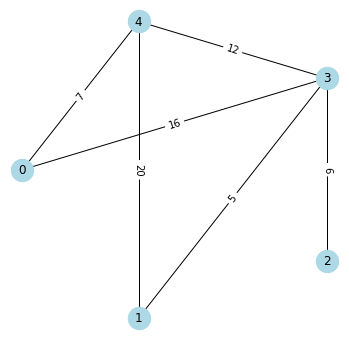

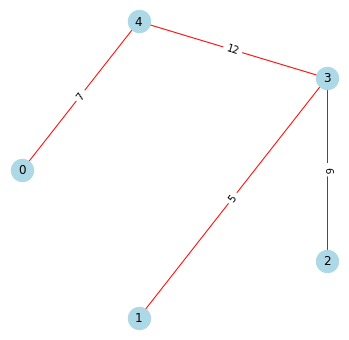

In [32]:
nodes = 5
probability = 0.4
G = gnp_random_connected_graph(nodes,probability)

for u,v in G.edges():
    G[u][v]["cost"] = random.randint(1,20)

draw(G, "lightblue", "black")
mst = nx.minimum_spanning_tree(G, weight='cost')
draw(mst, "lightblue", "red")

## Implemented manually

### Decision variables:

$$
x_{ij} = \begin{cases} 1 \text{ if edge } e=\{i,j\} \text{ is selected} \\
0 \text{ otherwise.}\end{cases}
$$

### Formulation

$$
\min \sum_{e=\{i,j\} \in E} c_{ij} x_{ij} \\
\sum_{e=\{i,j\} \in E} x_{ij} = |V| - 1 \\
\sum_{e=\{i,j\} \in E(S)} x_{ij} \le |S| - 1, \;\; \forall S \subset V, 2 < |S| \le |V| - 1  \\
x \le 1 \\ 
x \ge 0
$$

In [33]:
mst_model = gb.Model()

x = mst_model.addVars(G.edges(), ub = 1.0, vtype=gb.GRB.CONTINUOUS, name='x') # Decision Variables

mst_model.setObjective(x.prod(nx.get_edge_attributes(G, "cost"))) # Objective function

mst_model.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality') # Cardinality constraint

sec=0
for i in powerset(G.nodes()):
    if len(i) > 2 and len(i) <= G.number_of_nodes() - 1:
        sec = sec+1
        S = G.subgraph(i)

        if S.number_of_edges() > S.number_of_nodes() - 1:    
            mst_model.addConstr(gb.quicksum(x[i,j] if (i,j) in x else x[j,i] for i,j in S.edges()) <= S.number_of_nodes() - 1, 'Sec' + str(sec))

mst_model.update()
mst_model.write('mst.lp')

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 6 rows, 6 columns and 25 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 4e+00]

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.000000000e+01
Optimal solution: 30.0


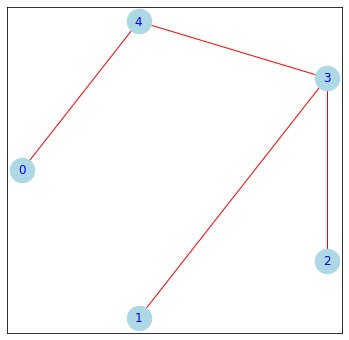

In [40]:
mst_model.optimize()
print ("Optimal solution:", mst_model.objVal)
drawSol(G,x)